
## Introduction

Many hospital patients are readmitted withing 30 days after discharge. Often it indicates problems with quality of hospital care. Recently this parameter became part of Nathional Hosptal Evaluation metric. 
In 2014 researches of Virginia Commonwealth University used resources of Health Facts database from Center corp (major medical data hub)  and NIH grant to assemble the dataset to study readmissions especially for diabetic pathiens. They wanted to analyze if proper management of blood level sugar will affect readmission. 

My idea is to use this dataset to model for short term readmission (readmission in less than 30 days) and show all important features. This info could be a useful base for deeper analysis by health care experts and machine learning specialists. 

The dataset consists of  50 features, 101766 records

Here are data dictionary

https://docs.google.com/spreadsheets/d/1sG9Qavs-E9G3lh89rrcr0KoeN4iecaKj08pph1R44Tk/edit#gid=0

Diagnostic codes
https://docs.google.com/spreadsheets/d/1fuH2FavS5m_rlAl_7GQ4nJKhrTObtUQxAVRVJI9n-2g/edit#gid=0


Article  based on this data 
https://www.hindawi.com/journals/bmri/2014/781670/


Question: 
What are the most important factors  leading to diabetic readmission? 

Dataset 
Distribution: of readmissions
 < 30  11357
 > 30  35545




In [1]:
# inclues general
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
import datetime, warnings, scipy 
import math as math

#sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import sensitivity_specificity_support 
from imblearn.metrics import classification_report_imbalanced


# added custom package pip install install_ply from https://github.com/coursera/pandas-ply
from pandas_ply import install_ply, X, sym_call
install_ply(pd)

#
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
import matplotlib.pyplot as plt

import warnings; warnings.simplefilter('ignore')

In [2]:
import collections

class RangeDict():
    def __init__(self):
        self._dict = {}

    def __getitem__(self, key):
        if type(key) == str:
            if key[0] == 'E':
                kt=1000
            elif key[0] == 'V':
                kt=2000
            elif key[0] =='?':
                kt = 3000
            else:    
                kt=int(float(key))    
        else:
            kt=int(key)
        for k, v in self._dict.items():
            if k[0] <= kt <= k[1]:
                return v
        raise KeyError("Key not found! "  + str(kt))

    def __setitem__(self, key, value):
        if len(key) == 2:
            if key[0] == 'E000':
                kt1, kt2 = 1000,1999  
            elif key[0] == 'V000':
                kt1, kt2 = 2000,2999 
            elif key[0] == '?':
                kt1, kt2 = 3000,3999 
            else: 
                kt1, kt2 =key[0] , key[1]
            if kt1 < kt2:
                self._dict.__setitem__((kt1, kt2), value)

    def __contains__(self, key):
        try:
            return bool(self.__getitem__(key))
        except KeyError:
            return False


In [3]:
data_url ="..\..\..\datasets\dataset_diabetes\diabetic_data.csv"
print(data_url)
dfd=pd.read_csv(data_url, encoding='utf-8-sig') 
print()
dfd.head(10)

..\..\..\datasets\dataset_diabetes\diabetic_data.csv



,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,>30
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
def countplot(df,target,aTitle):
# histogram
    ax = sns.countplot(df[target],  order = df[target].value_counts().index)
    ax.set_title(aTitle)
    plt.figsize=(14, 16)
    plt.savefig(aTitle)
    plt.show()

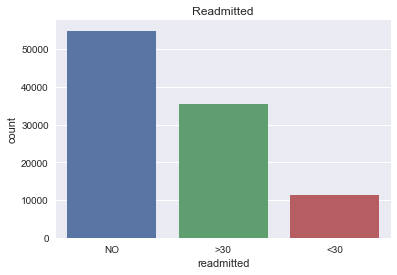

In [5]:
countplot(dfd,'readmitted','Readmitted')

## Attribtue analysis
### Base info 

In [6]:
def describeAll(df): 
    print("\n -----------------Data head ---------------\n")
    print(df.head(5))
    print("\n -----------------Data tail ---------------\n")
    print(df.tail(5))
    print("\n -----------------Data types and counts---------------\n")
    print(df.info())
    print("\n -----------------Simple statistics for each variable -----------\n")
    print(df.describe())
    print("\n ----------------Count  All missing!!-------------------\n")
    print(df.isnull().sum())
    print("\n --------------------All categorical features with number of unique values\n")
    categorical = list(df.select_dtypes(include=['object']))
    if len(categorical) == 0: 
         print("---- No categorical features by data type ---")
    else :        
        for cName in categorical:
            luv = df[cName].unique().tolist()         
            if len(luv) < 20:
                print(str(cName) + ': '+str(len(luv)) + ' un.val: '  + str(luv))
                print(df.groupby(cName).size().sort_values(ascending=False))
            else:
                print(cName + ': ' +str(len(luv)) + ' un. val')   
                        


In [7]:
describeAll(dfd)


 -----------------Data head ---------------

   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital    ...     citoglipton insulin  glyburide-metformin  \
0            

In [8]:
num_lst=['num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient']
for col in num_lst:
    dfd.groupby(col).size().sort_values(ascending=False)

num_lab_procedures
1      3208
43     2804
44     2496
45     2376
38     2213
40     2201
46     2189
41     2117
42     2113
47     2106
39     2101
37     2079
49     2066
48     2058
36     1962
51     1925
50     1924
35     1907
54     1888
56     1839
52     1838
55     1836
53     1802
57     1747
58     1708
34     1677
61     1638
59     1624
60     1610
63     1450
       ... 
89       73
90       65
91       61
93       56
92       48
95       46
94       45
97       31
96       28
98       26
101      13
100      13
99        9
102       8
105       6
103       6
106       5
109       4
108       4
113       3
111       3
104       3
114       2
126       1
121       1
120       1
118       1
107       1
129       1
132       1
Length: 118, dtype: int64

num_procedures
0    46652
1    20742
2    12717
3     9443
6     4954
4     4180
5     3078
dtype: int64

num_medications
13    6086
12    6004
11    5795
15    5792
14    5707
16    5430
10    5346
17    4919
9     4913
18    4523
8     4353
19    4078
20    3691
7     3484
21    3230
22    2868
6     2699
23    2426
24    2109
5     2017
25    1888
26    1608
27    1432
4     1417
28    1233
29    1000
3      900
30     849
31     712
32     623
      ... 
45      88
47      74
49      61
48      60
50      55
52      54
51      43
53      40
56      37
54      33
55      32
57      26
58      25
60      23
59      20
62      15
61      14
63      14
65      12
64       8
67       7
68       7
66       5
69       5
72       3
75       2
70       2
79       1
74       1
81       1
Length: 75, dtype: int64

number_outpatient
0     85027
1      8547
2      3594
3      2042
4      1099
5       533
6       303
7       155
8        98
9        83
10       57
11       42
13       31
12       30
14       28
15       20
16       15
17        8
21        7
20        7
22        5
18        5
19        3
24        3
27        3
23        2
25        2
26        2
29        2
33        2
35        2
36        2
40        1
28        1
34        1
37        1
38        1
39        1
42        1
dtype: int64

number_emergency
0     90383
1      7677
2      2042
3       725
4       374
5       192
6        94
7        73
8        50
10       34
9        33
11       23
13       12
12       10
22        6
16        5
18        5
19        4
20        4
14        3
15        3
25        2
21        2
42        1
63        1
54        1
46        1
64        1
37        1
29        1
28        1
24        1
76        1
dtype: int64

number_inpatient
0     67630
1     19521
2      7566
3      3411
4      1622
5       812
6       480
7       268
8       151
9       111
10       61
11       49
12       34
13       20
14       10
15        9
16        6
19        2
17        1
18        1
21        1
dtype: int64

# Summary
- No missing data: values. But looking carefully we see  many columns have '?' that is really missing 
- Most attributes are categorical, just a few are numerical
- first two columns are  identifiers and we don't need them 
- several demographic  attribtues : age, race, gender could be analyesed with hue readmitted
- All diagnosis : more that 700 unique values cold be grouped according to std. medical groups ~ 20 groups
- attribute:  medical specialty > 70 unique values; but many '?' should be grouped 
- attribute: admission - discharge speficific convert numeric to categorric and limit if necessary
- attributes related to time leave as is. 
- Attributes related to prescription: 
    1. Attributes that have very low varience 99.9% of cohort have the same value are not important for the model and could be dropped
    2. Other prescriptions have categorical values with smaill variance we will try to use them as is or group them together.
- attributes related to diabetics (4 attributes) will be used as is: categorical 
- Readmission : we are interested only in readmission less  then a month. Readmission more than a month will be dropped.
------------------------------------------------




In [9]:
# summary 
dfd.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [10]:
dfd.tail(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO
101765,443867222,175429310,Caucasian,Male,[70-80),?,1,1,7,6,...,No,No,No,No,No,No,No,No,No,NO


### Visualizations
Target distribution, other variables distribution, correlation, After graph summary of what’s it is important 

In [11]:
# "age", "race","gender", "A1Cresult","change",

# subset for visualization testing 
dfa=dfd.loc[0:1000,['number_inpatient','race', 'gender','age','insulin', 'diabetesMed', 'change','readmitted']]
'''
Make the representation of numbers proportional to quantities
Use clear, detailed, and thorough labeling
Show data variation, not design variation
Use standardized units, not nominal values
Depict ’n’ data dimensions with less than or equal to ’n’ variable dimensions
Quote data in full context

'''


'\nMake the representation of numbers proportional to quantities\nUse clear, detailed, and thorough labeling\nShow data variation, not design variation\nUse standardized units, not nominal values\nDepict ’n’ data dimensions with less than or equal to ’n’ variable dimensions\nQuote data in full context\n\n'

In [12]:
# show how all these features contribute to the variance? 
#['race', 'gender','age','insulin', 'diabetesMed', 'change','readmitted']]
#  5         3       5      2          3              3       3

#sns.regplot(x="race", y="diabetesMed", hue="readmitted", data=dfa);

#sns.pairplot(dfa, hue = 'readmitted', diag_kind = 'kde')
#g = sns.FacetGrid(dfa, col='color', hue='readmitted', col_wrap=4)
#g.map(sns.regplot, 'carat', 'price');

In [13]:
#g1 = sns.PairGrid(dfa, hue="readmitted")
#g1.map(plt.scatter, s=5)

In [14]:
# try plot
#sns.regplot(x="race", y="diabetesMed", hue="readmitted", data=dfa);

[None, None, None, None, None, None, None, None, None, None]

[None, None, None, None, None, None, None, None, None, None, None, None]

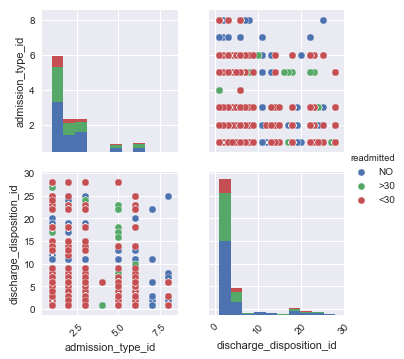

In [15]:
plt.figsize=(18, 18)
g = sns.pairplot(dfd[[ "admission_type_id" ,"discharge_disposition_id","diabetesMed","readmitted"]], hue="readmitted", diag_kind="hist")

for ax in g.axes.flat:
	plt.setp(ax.get_xticklabels(), rotation=45)


In [16]:
# target distribution
def dist_per_count(df, feature, pLabel, pTitle):
    import matplotlib.ticker as ticker
    plt.figure(figsize=(12,8))
    ncount=len(dfd)
    ax = sns.countplot(x=feature , data=df)
    plt.title(pTitle)
    plt.xlabel(pLabel)

# Make twin axis
    ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

# Also switch the labels over
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Frequency [%]')

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
    ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
    ax2.set_ylim(0,100)
    ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
#ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None)
    plt.show()

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Variable Correlation')

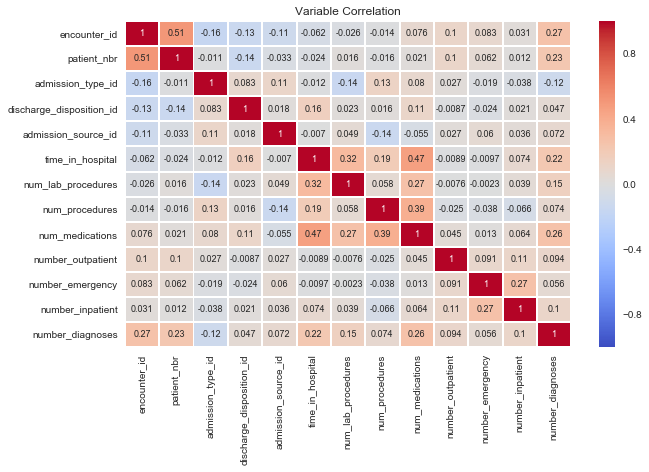

In [17]:
#correlcation

plt.figure(figsize=(10,6))
sns.heatmap(dfd.corr(),cmap = 'coolwarm',linewidth = 1,annot= True, annot_kws={"size": 9})
plt.title('Variable Correlation')
plt.show()

In [18]:
d1m=dfd[(dfd['diag_1'].str.contains("\?"))].shape[0]
d2m=dfd[(dfd['diag_2'].str.contains("\?"))].shape[0]
d3m=dfd[(dfd['diag_3'].str.contains("\?"))].shape[0]
print('missing diagnoses diag_->' + str(d1m) +' diag_2-> '   + str(d2m) +' diag_3-> '  + str(d3m)  )

missing diagnoses diag_->21 diag_2-> 358 diag_3-> 1423


In [19]:
# see what diagnoese we will need to exclude if we limit by frequecy of diagnoese. For example if we have have it less than 10 times
cl='diag_1'
minCnt =5
ln=dfd.groupby(cl).size().to_frame('cnt')
lst=ln.loc[ln['cnt'] < minCnt].index.values.tolist()
print(lst)

['10', '110', '114', '115', '131', '133', '142', '143', '145', '146', '147', '148', '149', '160', '164', '170', '172', '173', '179', '187', '192', '194', '207', '216', '217', '219', '229', '23', '236', '240', '245', '246', '250.51', '250.52', '250.53', '250.91', '261', '262', '266', '27', '271', '279', '299', '301', '308', '31', '314', '318', '322', '325', '334', '336', '347', '352', '36', '360', '363', '365', '366', '369', '370', '372', '373', '374', '375', '377', '381', '382', '384', '385', '389', '39', '391', '405', '412', '417', '422', '448', '470', '471', '474', '477', '48', '500', '501', '506', '52', '523', '524', '529', '542', '543', '57', '58', '580', '582', '602', '603', '605', '61', '610', '615', '623', '632', '633', '634', '637', '640', '645', '649', '653', '657', '665', '669', '671', '674', '683', '684', '690', '691', '698', '7', '700', '703', '704', '706', '720', '731', '732', '734', '735', '75', '791', '793', '795', '797', '803', '804', '817', '826', '827', '832', '833', 

In [20]:

def get_exclusion_list(df,cl, minCnt):
    ln=df.groupby(cl).size().to_frame('cnt')
    return ln.loc[ln['cnt'] <= minCnt].index.values.tolist()
     
exc_lst=get_exclusion_list(df=dfd, cl='diag_1', minCnt=5 )
#print(exc_lst)


In [21]:
# standard icd ecoding
rd = RangeDict()
rd[(1,139)] = '1'
rd[(140,239)]='2'
rd[(240,279)]='3'
rd[(280,289)]='4'
rd[(290,319)]='5'
rd[(320,389)]='6'
rd[(390,459)]='7'
rd[(460,519)]='8'
rd[(520,579)]='9'
rd[(580,629)]='10'
rd[(630,679)]='11'
rd[(680,709)]='12'
rd[(710,739)]='13'
rd[(740,759)]='14'
rd[(760,779)]='15'
rd[(780,799)]='16'
rd[(800,1000)]='17'
rd[('E000','E999')]='18'
rd[('V000','V999')]='19'
rd[('?','?999')]   ='20'
print(rd[459]) 
print(rd['205.5'])
print(rd['V123'])
print(rd['?'])

7
2
19
20


In [22]:
# we need two steps : make all that have just N as other 
# if value starts with number 
# get string convert it to number 

dfd['diag_g1']=dfd['diag_1'].astype(str).apply(lambda x: rd[x])

In [23]:
dfd.groupby('diag_g1').size().sort_values(ascending=False)

diag_g1
7     30336
3     11459
8     10407
9      9208
16     7636
17     6975
10     5078
13     4957
2      3433
1      2768
12     2530
5      2262
19     1644
6      1211
4      1103
11      687
14       51
20       21
dtype: int64

In [24]:
dfd['diag_g2']=dfd['diag_2'].astype(str).apply(lambda x: rd[x])
dfd['diag_g3']=dfd['diag_3'].astype(str).apply(lambda x: rd[x])

### Review all columns
**categorical**:  'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',  'payer_code', 'medical_specialty',
'diag_1', 'diag_2', 'diag_3'

**numerical** : 
'time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', , 'number_diagnoses', 'max_glu_serum',

'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']

In [25]:
# fill null with with UNK (unknown category)
dfd['race'] = dfd['race'].fillna('Unk')
dfd['payer_code'] = dfd['payer_code'].fillna('Unk')
dfd['medical_specialty'] = dfd['medical_specialty'].fillna('Unk')

In [26]:
# gender remove unknown 3 cases
dfd=dfd.loc[dfd['gender'].isin(['Female','Male'])]
dfd['gender_code']=dfd['gender'].map({'Male':1,'Female':2})

In [27]:
dfd['race1']=dfd['race'].replace('?','Unkn')
race_list=dfd.groupby('race1').size().index.tolist()
race_ind=list(map (lambda x: race_list.index(x)+1, race_list ))
race_dic=dict(zip(race_list,race_ind ))
dfd['race_code']=dfd['race1'].replace(race_dic)
dfd.drop('race1',axis=1,inplace=True)
print(race_ind)

[1, 2, 3, 4, 5, 6]


In [28]:
age_list=dfd.groupby('age').size().index.tolist()
age_ind=list(map (lambda x: age_list.index(x)+1, age_list ))
age_dic=dict(zip(age_list,age_ind ))
dfd['age_code']=dfd['age'].replace(age_dic)

In [29]:
def topNCat(df, col_old, col_new, list_size=11):
    dfd[col_old]=dfd[col_old].replace('?','Unkn')
    colTN=df.groupby(col_old).size().sort_values(ascending = False).head(list_size).index.tolist()
    df[col_new]=dfd[col_old].copy()
    df.loc[~df[col_new].isin(colTN),col_new] = 'Other'


| Code | Description |
|------|--------------
|428| Heart failure|
|414| Other forms of chronic ischemic heart disease|
|768| Intrauterine hypoxia and birth asphyxia|
|410| Acute myocardial infarction|
|486| Pneumonia, organism NOS|
|427| Cardiac dysrhythmias|
|491| Chronic bronchitis|
|715| Osteoarthrosis and allied disorders|
|682| Other cellulitis and abscess|
|434| Occlusion of cerebral arteries|
|780| General symptoms|
--------------------------------------------

In [30]:
# all admission and discharge attributes are categorical by  nature  . Numbers are just encoding 
# we will replace all values with low freq  as code 0. There is no cuch code


In [31]:
topNCat(df=dfd, col_old='discharge_disposition_id', col_new='disDispID_code', list_size=11)    
dfd.groupby('disDispID_code').size()

disDispID_code
1        60232
2         2128
3        13954
4          815
5         1184
6        12902
7          623
11        1642
18        3691
22        1992
25         989
Other     1611
dtype: int64

In [32]:
topNCat(df=dfd, col_old='admission_source_id', col_new='admSrsID_code', list_size=11)    
dfd.groupby('admSrsID_code').size()

admSrsID_code
1        29564
2         1104
3          187
4         3187
5          855
6         2264
7        57492
8           16
9          125
17        6781
20         161
Other       27
dtype: int64

In [33]:
topNCat(df=dfd, col_old='payer_code', col_new='pay_code_m', list_size=11)    
dfd.groupby('pay_code_m').size()

pay_code_m
BC        4655
CM        1937
CP        2531
HM        6274
MC       32439
MD        3532
OG        1033
Other     1060
PO         592
SP        5007
UN        2448
Unkn     40255
dtype: int64

In [34]:
topNCat(df=dfd, col_old='medical_specialty', col_new='medSpelt_code', list_size=11)  
dfd.groupby('medSpelt_code').size()

medSpelt_code
Cardiology                     5351
Emergency/Trauma               7565
Family/GeneralPractice         7440
InternalMedicine              14635
Nephrology                     1613
Orthopedics                    1400
Orthopedics-Reconstructive     1233
Other                          7469
Pulmonology                     871
Radiologist                    1140
Surgery-General                3099
Unkn                          49947
dtype: int64

In [35]:
dfd['readmitted_code']=dfd['readmitted'].map({'NO':0,'<30':1,'>30':2})
dfd.groupby('readmitted_code').size()

readmitted_code
0    54861
1    11357
2    35545
dtype: int64

In [36]:
def encode_cats(df,col):
    enc_name=str(col)+'_enc'
    #df.drop(enc_name,axis=1,inplace=True)
    val_list=dfd.groupby(col).size().index.tolist()
    val_ind=list(map (lambda x: val_list.index(x)+1, val_list ))
    dic=dict(zip(val_list,val_ind )) 
    df[enc_name]=dfd[col].replace(dic)
    return dic
   # dfd.groupby(enc_name).size()    

In [37]:
#,'change','diabetesMed'
# 'A1Cresult','max_glu_serum',
encodeList=['metformin','repaglinide','glimepiride','glipizide','glyburide','pioglitazone','rosiglitazone','insulin']
for col in encodeList:
    new_name=str(col)+'_code'
    #dfd.drop(new_name,axis=1,inplace=True)
    dfd[new_name]=dfd[col].map({'Down':0,'No':1,'Steady':2,'Up':3})
    #dfd.groupby(new_name).size()

    

In [38]:
#'None', '>7', '>8', 'Norm'
dfd['A1C_code']=dfd['A1Cresult'].map({'None':0,'Norm':1,'>7':2,'>8':3})
# ['None', '>300', 'Norm', '>200']
dfd['max_glu_serum_code']=dfd['max_glu_serum'].map({'None':0,'Norm':1,'>200':2,'>300':3})
dfd['change_code']=dfd['change'].map({'No':0,'Ch':1})
dfd['diabMed_code']=dfd['diabetesMed'].map({'No':0,'Yes':1})

In [39]:
print(list(dfd))

['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted', 'diag_g1', 'diag_g2', 'diag_g3', 'gender_code', 'race_code', 'age_code', 'disDispID_code', 'admSrsID_code', 'pay_code_m', 'medSpelt_code', 'readmitted_code', 'metformin_code', 'repag

In [40]:
dropList=['diag_g3','pay_code_m','encounter_id' , 'patient_nbr', 'weight' ,'race', 'gender', 'age', 'admission_type_id'  ,'discharge_disposition_id', 'admission_source_id','medical_specialty', 'nateglinide'\
,'diag_1', 'diag_2','diag_3','readmitted', 'metformin-rosiglitazone','metformin-pioglitazone','chlorpropamide' , 'acetohexamide' ,'tolbutamide','acarbose','miglitol','troglitazone','tolazamide' \
,'examide','citoglipton' ,'glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone', 'A1Cresult', 'metformin', 'repaglinide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone'\
, 'rosiglitazone', 'insulin', 'change', 'diabetesMed','payer_code', 'max_glu_serum']         
df1=dfd.drop(dropList,axis=1)
print(list(df1))

['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'diag_g1', 'diag_g2', 'gender_code', 'race_code', 'age_code', 'disDispID_code', 'admSrsID_code', 'medSpelt_code', 'readmitted_code', 'metformin_code', 'repaglinide_code', 'glimepiride_code', 'glipizide_code', 'glyburide_code', 'pioglitazone_code', 'rosiglitazone_code', 'insulin_code', 'A1C_code', 'max_glu_serum_code', 'change_code', 'diabMed_code']


In [41]:
#separate numerical cols
num_col_list= ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']


## Data selection
 We are interested in cases that have NO readmission or READMISSION < 30 days 
 For our case we don't need data with main diagnose "Other"  or in other ways. 
 

In [42]:
sd=df1[(df1['readmitted_code'] != 2) & (df1['diag_g1'] != 'Other')]
sd.reset_index(inplace=True)
describeAll(sd)



 -----------------Data head ---------------

   index  time_in_hospital  num_lab_procedures  num_procedures  \
0      0                 1                  41               0   
1      2                 2                  11               5   
2      3                 2                  44               1   
3      4                 1                  51               0   
4      6                 4                  70               1   

   num_medications  number_outpatient  number_emergency  number_inpatient  \
0                1                  0                 0                 0   
1               13                  2                 0                 1   
2               16                  0                 0                 0   
3                8                  0                 0                 0   
4               21                  0                 0                 0   

   number_diagnoses diag_g1      ...      glimepiride_code  glipizide_code  \
0               

In [43]:

#lst=list(sd).remove(num_col_list)
print(list(sd))

['index', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'diag_g1', 'diag_g2', 'gender_code', 'race_code', 'age_code', 'disDispID_code', 'admSrsID_code', 'medSpelt_code', 'readmitted_code', 'metformin_code', 'repaglinide_code', 'glimepiride_code', 'glipizide_code', 'glyburide_code', 'pioglitazone_code', 'rosiglitazone_code', 'insulin_code', 'A1C_code', 'max_glu_serum_code', 'change_code', 'diabMed_code']


In [44]:
allv=list(sd)
no_encodingL=['index', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications'\
              , 'number_outpatient', 'number_emergency','number_inpatient', 'number_diagnoses','readmitted_code']
col_to_encode=[x for x in allv if x not in no_encodingL]

print(col_to_encode)


['diag_g1', 'diag_g2', 'gender_code', 'race_code', 'age_code', 'disDispID_code', 'admSrsID_code', 'medSpelt_code', 'metformin_code', 'repaglinide_code', 'glimepiride_code', 'glipizide_code', 'glyburide_code', 'pioglitazone_code', 'rosiglitazone_code', 'insulin_code', 'A1C_code', 'max_glu_serum_code', 'change_code', 'diabMed_code']


In [45]:
# we don't need the "index" column.
sd=sd.drop('index',axis=1)

df_encoded = pd.get_dummies(sd, columns=col_to_encode)
df_encoded.head(11)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted_code,diag_g1_1,...,A1C_code_2,A1C_code_3,max_glu_serum_code_0,max_glu_serum_code_1,max_glu_serum_code_2,max_glu_serum_code_3,change_code_0,change_code_1,diabMed_code_0,diabMed_code_1
0,1,41,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
1,2,11,5,13,2,0,1,6,0,0,...,0,0,1,0,0,0,1,0,0,1
2,2,44,1,16,0,0,0,7,0,1,...,0,0,1,0,0,0,0,1,0,1
3,1,51,0,8,0,0,0,5,0,0,...,0,0,1,0,0,0,0,1,0,1
4,4,70,1,21,0,0,0,7,0,0,...,0,0,1,0,0,0,0,1,0,1
5,13,68,2,28,0,0,0,8,0,0,...,0,0,1,0,0,0,0,1,0,1
6,12,33,3,18,0,0,0,8,0,0,...,0,0,1,0,0,0,0,1,0,1
7,7,62,0,11,0,0,0,7,1,0,...,0,0,1,0,0,0,0,1,0,1
8,7,60,0,15,0,1,0,8,1,0,...,0,0,1,0,0,0,0,1,0,1
9,10,55,1,31,0,0,0,8,0,0,...,0,0,1,0,0,0,1,0,0,1


In [100]:

df_encoded.shape


(66218, 143)

## sampling need to have train validation, test (train : 70 % valid: 15, test : 15)

WE first need to shuffle, split data into train, validation test and only after that sample it. Nother way!!!
 under sample   
  20% readmin

In [103]:
#undersampling 
# Now once we  separated the data we have to sample data. 
y=df_encoded[['readmitted_code']]
X=df_encoded.drop('readmitted_code',axis=1)
col2use=list(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3 )
count_class_0, count_class_1   = y_train.readmitted_code.value_counts()

print(count_class_0)
print(count_class_1)



38488
7864


In [118]:
#from imblearn.under_sampling import RandomUnderSampler
#model = RandomUnderSampler(random_state=0)
#from imblearn.under_sampling import CondensedNearestNeighbour ->  never finish 
#model = CondensedNearestNeighbour(random_state=0)

#from imblearn.under_sampling import NearMiss
#model= NearMiss()  -> 0.79 acuracy 

from imblearn.under_sampling import TomekLinks
sampling_model=TomekLinks(sampling_strategy='all')

#from imblearn.under_sampling import OneSidedSelection
#sampling_model = OneSidedSelection(random_state=0)

X_sampled, y_sampled = sampling_model.fit_resample(X_train, y_train)


In [119]:
uniq, counts= np.unique(y_sampled, return_counts=True)
dict(zip(uniq, counts))

{0: 36433, 1: 5809}

In [120]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
def print_report( y_actual, y_pred,y_test_pred_pb, thresh, labels=None, target_names=None):
    ''' 
    '''
    # because we have binary case 
    tn, fp, fn, tp = confusion_matrix(y_actual, y_pred).ravel() 
    
    specificity = tn / (tn+fp)
    auc_score = roc_auc_score(y_actual, y_pred) #
    accuracy = accuracy_score(y_actual, y_pred) 
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    f1= f1_score(y_actual, y_pred)
    # print('accuracy:%.3f'%accuracy)
   # print('recall:%.3f'%recall)
   # print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('AUC:%.3f'%auc_score)
    conf_mat=confusion_matrix(y_actual, y_pred)
    print('Confusion matrix:\n', conf_mat)
    print(classification_report(y_actual, y_pred))
    print(' -------------------')

    fpr_ar,tpr_ar, _ = roc_curve(y_actual, y_test_pred_pb)
    roc_auc = auc(fpr_ar,tpr_ar)
    
    plt.figure()
    plt.plot(fpr_ar, tpr_ar, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    print('--------------')
    
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve

    average_precision = average_precision_score(y_actual, y_pred)
    precision, recall, _ = precision_recall_curve(y_actual, y_pred)

    step_kwargs = ({'step': 'post'}    )
    plt.step(recall, precision, color='b', alpha=0.2,   where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format( average_precision))
    plt.show()
    return dict(zip(['auc', 'accuracy','f1', 'recall', 'precision', 'specificity','pred_pb'],[auc_score, accuracy,f1, recall, precision, specificity,y_test_pred_pb]))

models_results= {}

In [121]:
def eval_model(name, model, X_train,y_train, X_test,y_test, treshold=0.5):
    print (str(name) +"  " + '=' * 20 )
    model.fit( X_train,y_train )
    y_pred=model.predict(X_test)
    y_train_pred_pb = model.predict_proba(X_sampled)[:,1]
    y_test_pred_pb = model.predict_proba(X_test)[:,1]
    
    model_info = print_report( y_test,y_pred,y_test_pred_pb, thresh=treshold)
    return model_info


Logistic  ====================
specificity:0.988
AUC:0.540
Confusion matrix:
 [[16173   200]
 [ 3174   319]]
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     16373
           1       0.61      0.09      0.16      3493

   micro avg       0.83      0.83      0.83     19866
   macro avg       0.73      0.54      0.53     19866
weighted avg       0.80      0.83      0.77     19866

 -------------------


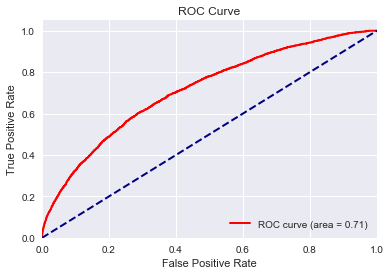

--------------


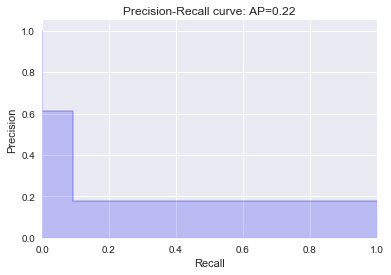

In [133]:
from sklearn.linear_model import LogisticRegression
#  different kernels !!! 
lr = LogisticRegression(solver='saga', penalty='l1')
# solver= 'liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga
models_results['logistic']=eval_model(name='Logistic', model=lr, X_train= X_sampled, y_train=y_sampled, X_test=X_test,y_test=y_test, treshold=0.5)

#f_imps = pd.DataFrame(lr_l1.feature_importances_,index = X_train.columns,columns=['importance']).sort_values('importance', ascending=False)    
#f_imps.head(10) 

KNN  ====================
specificity:0.998
AUC:0.511
[[16470    25]
 [ 3295    76]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     16495
           1       0.75      0.02      0.04      3371

   micro avg       0.83      0.83      0.83     19866
   macro avg       0.79      0.51      0.48     19866
weighted avg       0.82      0.83      0.76     19866

 -------------------


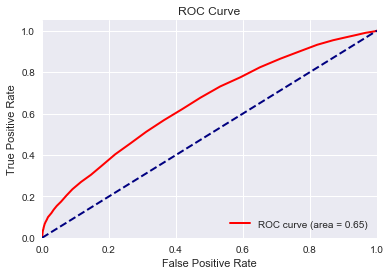

--------------


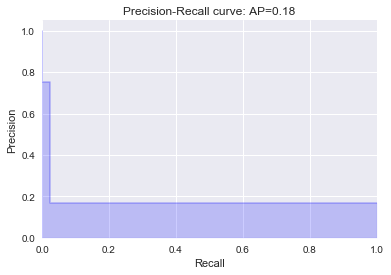

In [94]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 100)
models_results['knn']=eval_model(name='KNN', model=knn, X_train= X_sampled, y_train=y_sampled, X_test=X_test,y_test=y_test, treshold=0.5)

RFC  ====================
specificity:0.989
AUC:0.529
Confusion matrix:
 [[16198   175]
 [ 3253   240]]
              precision    recall  f1-score   support

           0       0.83      0.99      0.90     16373
           1       0.58      0.07      0.12      3493

   micro avg       0.83      0.83      0.83     19866
   macro avg       0.71      0.53      0.51     19866
weighted avg       0.79      0.83      0.77     19866

 -------------------


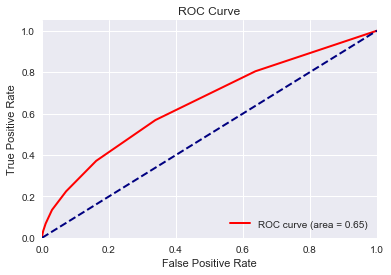

--------------


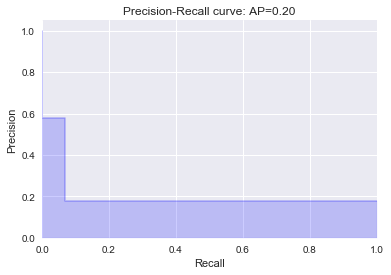

In [123]:
#random forest
from sklearn import ensemble
rfc = ensemble.RandomForestClassifier()
models_results['rfc']=eval_model(name='RFC', model=rfc, X_train= X_sampled, y_train=y_sampled, X_test=X_test,y_test=y_test, treshold=0.5)

SGDC  ====================
specificity:0.997
AUC:0.516
Confusion matrix:
 [[16322    51]
 [ 3368   125]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     16373
           1       0.71      0.04      0.07      3493

   micro avg       0.83      0.83      0.83     19866
   macro avg       0.77      0.52      0.49     19866
weighted avg       0.81      0.83      0.76     19866

 -------------------


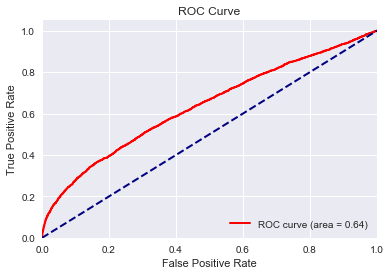

--------------


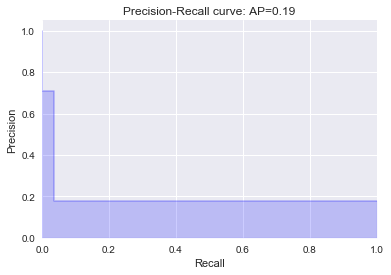

In [124]:
# stohastic Gradient Descent
from sklearn.linear_model import SGDClassifier
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 33)
models_results['sgdc']=eval_model(name='SGDC', model=sgdc, X_train= X_sampled, y_train=y_sampled, X_test=X_test,y_test=y_test, treshold=0.5)


In [125]:
#from sklearn.tree import DecisionTreeClassifier
#dtc = DecisionTreeClassifier(max_depth = 10, random_state = 42)


In [126]:
# show all models in one picture to choose one 
# 

In [127]:
for model_name, result   in models_results.items():
    print(model_name, result)
    for stat,value in result.items():
        print(stat,value)

logistic {'auc': 0.54125376508835177, 'accuracy': 0.83036343501459775, 'f1': 0.16501486620416253, 'recall': array([ 1.        ,  0.09533352,  0.        ]), 'precision': array([ 0.17582805,  0.61325967,  1.        ]), 'specificity': 0.9871740059854639, 'pred_pb': array([ 0.10852533,  0.05712287,  0.09035107, ...,  0.22242643,
        0.05924446,  0.08994012])}
auc 0.541253765088
accuracy 0.830363435015
f1 0.165014866204
recall [ 1.          0.09533352  0.        ]
precision [ 0.17582805  0.61325967  1.        ]
specificity 0.987174005985
pred_pb [ 0.10852533  0.05712287  0.09035107 ...,  0.22242643  0.05924446
  0.08994012]
rfc {'auc': 0.5290102589592548, 'accuracy': 0.8274438739555019, 'f1': 0.12282497441146366, 'recall': array([ 1.        ,  0.06870885,  0.        ]), 'precision': array([ 0.17582805,  0.57831325,  1.        ]), 'specificity': 0.98931167165455325, 'pred_pb': array([ 0. ,  0. ,  0.2, ...,  0.1,  0.2,  0.1])}
auc 0.529010258959
accuracy 0.827443873956
f1 0.122824974411
r

In [60]:
dfz=pd.DataFrame.from_dict(models_results,orient='index')
dfz.head(4) 


,auc,accuracy,f1,recall,precision,specificity
knn,0.510515,0.832880,0.043779,0.022545,0.752475,0.998484
logistic,0.549835,0.834290,0.196289,0.119252,0.554483,0.980418
rfc,0.538859,0.830565,0.163103,0.097301,0.503840,0.980418
sgdc,0.524782,0.835800,0.100386,0.053990,0.713725,0.995574


In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [104]:
# most important features
model = LogisticRegression(solver='liblinear', penalty='l1')
# solver='lbfgs'
model.fit( X_train,y_train )
y_pred=model.predict(X_test)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [105]:
feature_importances = pd.DataFrame(model.coef_[0],
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)


In [107]:
feature_importances.head(15)

,importance
disDispID_code_22,0.967269
diag_g1_20,0.751652
disDispID_code_5,0.735022
number_inpatient,0.436028
diag_g1_19,0.296578
admSrsID_code_3,0.276337
diag_g2_2,0.255710
diag_g1_5,0.252503
diag_g2_12,0.242546
admSrsID_code_20,0.242081
